## Colin's Pipeline Experiments
### Objectives:
- Create a SingleImagePipeline so we can run fast-iteration experiments on just a single image
- Create a CentraPipeline that calls SingleImagePipeline
- Modularize the soccer_net_pipeline and migrate all operations to SingleImagePipeline
- Run all systematic ops from CentralPipeline (more than one tracklet)

### Main benefit from creating a `SingleImagePipeline` and a `CentralPipeline`
Decoupling large-scale systematic training versus testing. The main pipeline trains the model, creates output processed images and does so by systematically traversing all the tracklets. I want to be able to see what pre-processing is happening to the image so I can understand what is being fed to the model. I also just want to be able to pass a single raw image to the model so I can get fast results. Right now everything is coupled together by all the tracklets, and I don't want to traverse all of them or even a single tracklet, but maybe only a single image from a single tracklet.

### Quick Run Block

In [1]:
#pip install yacs
#%pip install pytorch_lightning

## Code

In [ ]:
import sys
from pathlib import Path
import os

sys.path.append(str(Path.cwd().parent.parent))
print(str(Path.cwd().parent.parent))
print("Current working directory: ", os.getcwd())

from ModelDevelopment.CentralPipeline import CentralPipeline
from ModelDevelopment.ImageBatchPipeline import ImageBatchPipeline
from DataProcessing.DataPreProcessing import DataPaths

c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition
Current working directory:  c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\ModelDevelopment\experiments


In [ ]:
pipeline = CentralPipeline(
  input_data_path=DataPaths.TRAIN_DATA_DIR.value,
  output_processed_data_path=DataPaths.PROCESSED_DATA_OUTPUT_DIR_TRAIN.value,
  single_image_pipeline=False,
  display_transformed_image_sample=True,
  num_image_samples=1
  )

[2025-03-05 09:17:50] - [INFO]: DataPreProcessing initialized. Universe of available data paths:
[2025-03-05 09:17:50] - [INFO]: ROOT_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted
[2025-03-05 09:17:50] - [INFO]: TEST_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted\test\images
[2025-03-05 09:17:50] - [INFO]: TRAIN_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted\train\images
[2025-03-05 09:17:50] - [INFO]: CHALLENGE_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted\challenge\images
[2025-03-05 09:17:50] - [INFO]: PRE_TRAINED_MODELS_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\pre_trained_models
[2025-03-05 09:17:50] - [INFO]: REID_PRE_TRAINED: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\pre_trained_

[2025-03-05 09:17:50] - [INFO]: Running the SoccerNet pipeline.
[2025-03-05 09:17:50] - [INFO]: Using single-process GPU mode to generate features.


Loading tracklets (GPU):   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\colin\miniconda3\envs\UBC\Lib\site-packages\pytorch_lightning\utilities\migration\migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.1.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\pre_trained_models\reid\dukemtmcreid_resnet50_256_128_epoch_120.ckpt`


using GPU


[2025-03-05 09:17:54] - [INFO]: Saved features for tracklet with shape (1, 2048)


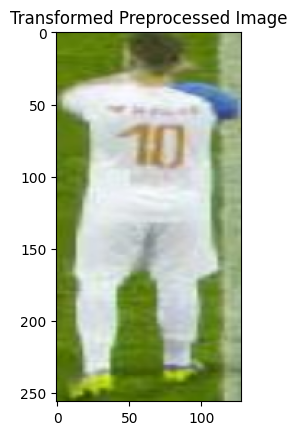

[2025-03-05 09:17:54] - [INFO]: Running model chain on preprocessed image(s).


In [ ]:
pipeline.run_soccernet_pipeline(
  num_tracklets=1,
  num_images_per_tracklet=1)